In [33]:
!pip install datasets
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import pandas as pd
import numpy as np
from transformers import BertModel, BertTokenizerFast, AdamW
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import os

In [36]:
from sklearn.model_selection import train_test_split

df_train = pd.read_json('./train_set.json')
df_test = pd.read_json('./test_set.json')

train_text, val_text, train_labels, val_labels = train_test_split(df_train['text'], df_train['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify=df_train['label'])

In [38]:
bert = BertModel.from_pretrained("bert-base-uncased")
for param in bert.parameters():
    param.requires_grad = False

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<AxesSubplot:>

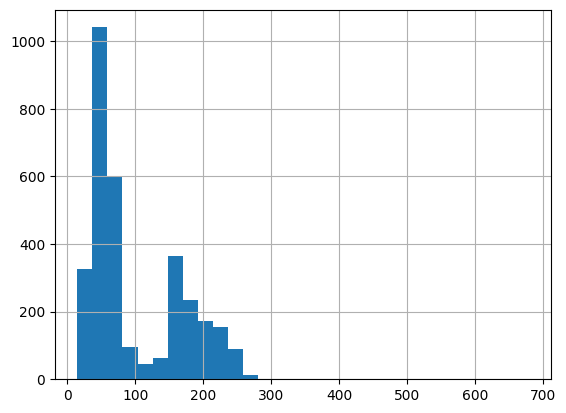

In [39]:
import matplotlib
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [40]:
max_seq_len=300

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())


# tokenize and encode sequences in the training set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

In [54]:
class Fine_Tuned(nn.Module):

    def __init__(self, bert):
        super(Fine_Tuned, self).__init__()

        self.bert = bert 

        self.layers = nn.Sequential(
            
            #nn.Dropout(0.05),
            nn.Linear(768, 2),
            #nn.ReLU(),
            #nn.Linear(10, 2),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, sent_id, mask):
        out = self.layers(self.bert(sent_id, attention_mask=mask, return_dict=False)[1])
        return out

In [57]:
batch_size = 16
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


model = Fine_Tuned(bert)
#model = model.to(device)
optimizer = AdamW(model.parameters(), lr = 3e-4)
our_loss  = nn.NLLLoss() 
epochs=10



In [58]:
# function to train the model
def train():
  model.train()
  total_preds=[]
  total_loss=0
  for step,batch in enumerate(train_dataloader):
    sent_id, mask, labels = batch
    model.zero_grad()        
    
    preds = model(sent_id, mask)
    loss = our_loss(preds, labels)
    total_loss+=loss.item()
    loss.backward()
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    preds=preds.detach().cpu().numpy()
    total_preds.append(preds)
    #if (step%5==0):
    print(loss.item())

  avg_loss = total_loss / len(train_dataloader)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [59]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  model.eval()
  total_loss=0
  total_preds = []

  for step,batch in enumerate(val_dataloader):
    sent_id, mask, labels = batch
    with torch.no_grad():
      preds = model(sent_id, mask)
      loss = our_loss(preds,labels)
      total_loss +=  loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)
      #if (step%5==0):
      print(loss.item())

  avg_loss = total_loss / len(val_dataloader) 
  total_preds  = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

In [60]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
0.8011395335197449
0.7624796032905579
0.7392663955688477
0.6808015704154968
0.709633469581604
0.6816026568412781
0.6924834251403809
0.6953840255737305
0.7230537533760071
0.7658489346504211
0.7055421471595764
0.698900043964386
0.7018128037452698
0.7181708216667175
0.7169591188430786
0.6491988897323608
0.6871659755706787
0.6479238271713257
0.6894137263298035
0.7886337637901306
0.6849039793014526
0.714969277381897
0.6899555921554565
0.6604249477386475
0.6621623039245605
0.7254096269607544
0.6680049300193787
0.6876627802848816
0.709243655204773
0.6911078095436096
0.7019091248512268
0.7086442112922668
0.6892590522766113
0.6557296514511108
0.7478184103965759
0.6872332096099854
0.706567645072937
0.7134526968002319
0.7151085138320923
0.6990151405334473
0.6975783705711365
0.6642734408378601
0.6923296451568604
0.7432029843330383
0.6693872213363647
0.7155724167823792
0.6440452933311462
0.7102687358856201
0.6488629579544067
0.7049989700317383
0.7090084552764893
0.6882928013801575
0.

In [29]:
val_seq_sub = torch.tensor(tokens_val['input_ids'][:100])
val_mask_sub = torch.tensor(tokens_val['attention_mask'][:100])
val_y_sub = torch.tensor(val_labels.tolist()[:100])
val_output=model(val_seq,val_mask)
labels=val_output.argmax(dim=1)
(labels==val_y_sub).float().sum()

NameError: name 'output' is not defined